# Task 2: ARIMA Model for Tesla Stock Price Forecasting

This notebook implements an ARIMA model to forecast Tesla (TSLA) stock prices
using historical time series data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
import yfinance as yf

tsla_data = yf.download(
    "TSLA",
    start="2015-01-01",
    end="2026-01-15",
    auto_adjust=True,
    progress=False
)

tsla_prices = tsla_data["Close"]
tsla_prices.head()


c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


Ticker,TSLA
Date,
2015-01-02,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333


In [4]:
train = tsla_prices.loc[:'2024-12-31']
test = tsla_prices.loc['2025-01-01':]


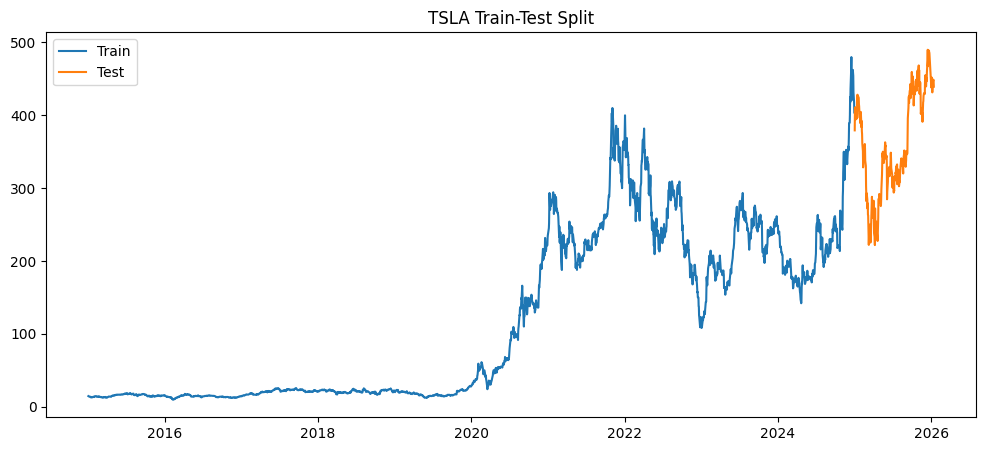

In [5]:
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.title("TSLA Train-Test Split")
plt.show()


In [6]:
model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True
)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8183.054
Date:                Sun, 25 Jan 2026   AIC                          16368.109
Time:                        15:11:09   BIC                          16373.939
Sample:                             0   HQIC                         16370.225
                               - 2516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.2337      0.442     88.858      0.000      38.368      40.099
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             11691.05
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             536.79   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
forecast = model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)


c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


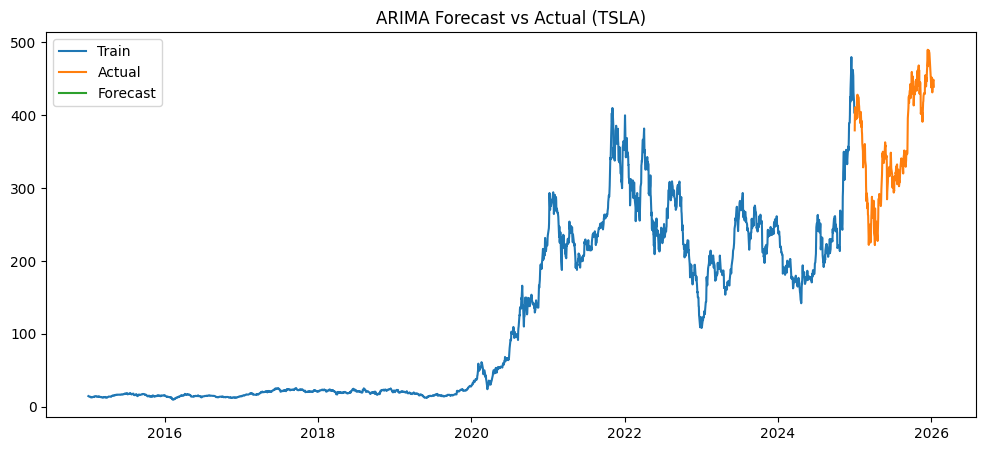

In [8]:
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual (TSLA)")
plt.show()


In [10]:
forecast_values = forecast.values
test_values = test.values


In [12]:
np.isnan(forecast_values).sum()
np.isnan(test_values).sum()


np.int64(0)

In [14]:
forecast.head()
forecast.tail()
forecast.isna().sum()


np.int64(259)

In [15]:
tsla_prices = tsla_prices.dropna()
tsla_prices.index = pd.to_datetime(tsla_prices.index)


In [16]:
tsla_prices = tsla_prices.asfreq("B")  # business days
tsla_prices = tsla_prices.ffill()


In [17]:
train = tsla_prices[:'2024-12-31']
test = tsla_prices['2025-01-01':]


In [18]:
len(train), len(test)


(2608, 271)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()


In [20]:
forecast = model_fit.forecast(steps=len(test))


In [21]:
forecast.isna().sum()


np.int64(0)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test.values, forecast.values)
rmse = np.sqrt(mean_squared_error(test.values, forecast.values))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 68.4493359695251
RMSE: 81.50613449797844
